In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename));

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_2025.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_1571.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_227.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_926.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_907.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_528.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_844.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_830.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_2215.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_1203.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_1756.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_299.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_502.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_875.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_755.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_2200.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_1909.jpg
/kaggle/input/eurosat-rgb/2750/SeaLake/SeaLake_1960.jpg
/k

In [6]:
!pip install triton

In [7]:
!pip install mamba-ssm
!pip install mamba-ssm[causal-conv1d]

In [10]:
# Copyright (c) 2023, Tri Dao, Albert Gu.

import torch
import torch.nn.functional as F
from mamba_ssm.utils.torch import custom_bwd, custom_fwd

from einops import rearrange, repeat

try:
    from causal_conv1d import causal_conv1d_fn
    import causal_conv1d_cuda
except ImportError:
    causal_conv1d_fn = None
    causal_conv1d_cuda = None

from mamba_ssm.ops.triton.layer_norm import _layer_norm_fwd

import selective_scan_cuda


class SelectiveScanFn(torch.autograd.Function):

    @staticmethod
    def forward(ctx, u, delta, A, B, C, D=None, z=None, delta_bias=None, delta_softplus=False,
                return_last_state=False):
        if u.stride(-1) != 1:
            u = u.contiguous()
        if delta.stride(-1) != 1:
            delta = delta.contiguous()
        if D is not None:
            D = D.contiguous()
        if B.stride(-1) != 1:
            B = B.contiguous()
        if C.stride(-1) != 1:
            C = C.contiguous()
        if z is not None and z.stride(-1) != 1:
            z = z.contiguous()
        if B.dim() == 3:
            B = rearrange(B, "b dstate l -> b 1 dstate l")
            ctx.squeeze_B = True
        if C.dim() == 3:
            C = rearrange(C, "b dstate l -> b 1 dstate l")
            ctx.squeeze_C = True
        out, x, *rest = selective_scan_cuda.fwd(u, delta, A, B, C, D, z, delta_bias, delta_softplus)
        ctx.delta_softplus = delta_softplus
        ctx.has_z = z is not None
        last_state = x[:, :, -1, 1::2]  # (batch, dim, dstate)
        if not ctx.has_z:
            ctx.save_for_backward(u, delta, A, B, C, D, delta_bias, x)
            return out if not return_last_state else (out, last_state)
        else:
            ctx.save_for_backward(u, delta, A, B, C, D, z, delta_bias, x, out)
            out_z = rest[0]
            return out_z if not return_last_state else (out_z, last_state)

    @staticmethod
    def backward(ctx, dout, *args):
        if not ctx.has_z:
            u, delta, A, B, C, D, delta_bias, x = ctx.saved_tensors
            z = None
            out = None
        else:
            u, delta, A, B, C, D, z, delta_bias, x, out = ctx.saved_tensors
        if dout.stride(-1) != 1:
            dout = dout.contiguous()
        # The kernel supports passing in a pre-allocated dz (e.g., in case we want to fuse the
        # backward of selective_scan_cuda with the backward of chunk).
        # Here we just pass in None and dz will be allocated in the C++ code.
        du, ddelta, dA, dB, dC, dD, ddelta_bias, *rest = selective_scan_cuda.bwd(
            u, delta, A, B, C, D, z, delta_bias, dout, x, out, None, ctx.delta_softplus,
            False  # option to recompute out_z, not used here
        )
        dz = rest[0] if ctx.has_z else None
        dB = dB.squeeze(1) if getattr(ctx, "squeeze_B", False) else dB
        dC = dC.squeeze(1) if getattr(ctx, "squeeze_C", False) else dC
        return (du, ddelta, dA, dB, dC,
                dD if D is not None else None,
                dz,
                ddelta_bias if delta_bias is not None else None,
                None,
                None)


def rms_norm_forward(
    x,
    weight,
    bias,
    eps=1e-6,
    is_rms_norm=True,
):
    # x (b l) d
    if x.stride(-1) != 1:
        x = x.contiguous()
    weight = weight.contiguous()
    if bias is not None:
        bias = bias.contiguous()
    y = _layer_norm_fwd(
        x, weight, bias, eps, None, residual_dtype=None, is_rms_norm=is_rms_norm
    )[0]
    # y (b l) d
    return y


def selective_scan_fn(u, delta, A, B, C, D=None, z=None, delta_bias=None, delta_softplus=False,
                     return_last_state=False):
    """if return_last_state is True, returns (out, last_state)
    last_state has shape (batch, dim, dstate). Note that the gradient of the last state is
    not considered in the backward pass.
    """
    return SelectiveScanFn.apply(u, delta, A, B, C, D, z, delta_bias, delta_softplus, return_last_state)


def selective_scan_ref(u, delta, A, B, C, D=None, z=None, delta_bias=None, delta_softplus=False,
                      return_last_state=False):
    """
    u: r(B D L)
    delta: r(B D L)
    A: c(D N) or r(D N)
    B: c(D N) or r(B N L) or r(B N 2L) or r(B G N L) or (B G N L)
    C: c(D N) or r(B N L) or r(B N 2L) or r(B G N L) or (B G N L)
    D: r(D)
    z: r(B D L)
    delta_bias: r(D), fp32

    out: r(B D L)
    last_state (optional): r(B D dstate) or c(B D dstate)
    """
    dtype_in = u.dtype
    u = u.float()
    delta = delta.float()
    if delta_bias is not None:
        delta = delta + delta_bias[..., None].float()
    if delta_softplus:
        delta = F.softplus(delta)
    batch, dim, dstate = u.shape[0], A.shape[0], A.shape[1]
    is_variable_B = B.dim() >= 3
    is_variable_C = C.dim() >= 3
    if A.is_complex():
        if is_variable_B:
            B = torch.view_as_complex(rearrange(B.float(), "... (L two) -> ... L two", two=2))
        if is_variable_C:
            C = torch.view_as_complex(rearrange(C.float(), "... (L two) -> ... L two", two=2))
    else:
        B = B.float()
        C = C.float()
    x = A.new_zeros((batch, dim, dstate))
    ys = []
    deltaA = torch.exp(torch.einsum('bdl,dn->bdln', delta, A))
    if not is_variable_B:
        deltaB_u = torch.einsum('bdl,dn,bdl->bdln', delta, B, u)
    else:
        if B.dim() == 3:
            deltaB_u = torch.einsum('bdl,bnl,bdl->bdln', delta, B, u)
        else:
            B = repeat(B, "B G N L -> B (G H) N L", H=dim // B.shape[1])
            deltaB_u = torch.einsum('bdl,bdnl,bdl->bdln', delta, B, u)
    if is_variable_C and C.dim() == 4:
        C = repeat(C, "B G N L -> B (G H) N L", H=dim // C.shape[1])
    last_state = None
    for i in range(u.shape[2]):
        x = deltaA[:, :, i] * x + deltaB_u[:, :, i]
        if not is_variable_C:
            y = torch.einsum('bdn,dn->bd', x, C)
        else:
            if C.dim() == 3:
                y = torch.einsum('bdn,bn->bd', x, C[:, :, i])
            else:
                y = torch.einsum('bdn,bdn->bd', x, C[:, :, :, i])
        if i == u.shape[2] - 1:
            last_state = x
        if y.is_complex():
            y = y.real * 2
        ys.append(y)
    y = torch.stack(ys, dim=2) # (batch dim L)
    out = y if D is None else y + u * rearrange(D, "d -> d 1")
    if z is not None:
        out = out * F.silu(z)
    out = out.to(dtype=dtype_in)
    return out if not return_last_state else (out, last_state)


class MambaInnerFn(torch.autograd.Function):

    @staticmethod
    @custom_fwd
    def forward(ctx, xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
                out_proj_weight, out_proj_bias,
                A, B=None, C=None, D=None, delta_bias=None, B_proj_bias=None,
                C_proj_bias=None, delta_softplus=True, checkpoint_lvl=1, b_rms_weight=None, c_rms_weight= None, dt_rms_weight= None, b_c_dt_rms_eps=1e-6):
        """
             xz: (batch, dim, seqlen)
        """
        assert causal_conv1d_cuda is not None, "causal_conv1d_cuda is not available. Please install causal-conv1d."
        assert checkpoint_lvl in [0, 1]
        L = xz.shape[-1]
        delta_rank = delta_proj_weight.shape[1]
        d_state = A.shape[-1] * (1 if not A.is_complex() else 2)
        if torch.is_autocast_enabled():
            x_proj_weight = x_proj_weight.to(dtype=torch.get_autocast_gpu_dtype())
            delta_proj_weight = delta_proj_weight.to(dtype=torch.get_autocast_gpu_dtype())
            out_proj_weight = out_proj_weight.to(dtype=torch.get_autocast_gpu_dtype())
            out_proj_bias = (out_proj_bias.to(dtype=torch.get_autocast_gpu_dtype())
                             if out_proj_bias is not None else None)
        if xz.stride(-1) != 1:
            xz = xz.contiguous()
        conv1d_weight = rearrange(conv1d_weight, "d 1 w -> d w")
        x, z = xz.chunk(2, dim=1)
        conv1d_bias = conv1d_bias.contiguous() if conv1d_bias is not None else None
        conv1d_out = causal_conv1d_cuda.causal_conv1d_fwd(
            x, conv1d_weight, conv1d_bias, None, None, None, True
        )
        # We're being very careful here about the layout, to avoid extra transposes.
        # We want delta to have d as the slowest moving dimension
        # and L as the fastest moving dimension, since those are what the ssm_scan kernel expects.
        x_dbl = F.linear(rearrange(conv1d_out, 'b d l -> (b l) d'), x_proj_weight)  # (bl d)
        delta = rearrange(delta_proj_weight @ x_dbl[:, :delta_rank].t(), "d (b l) -> b d l", l = L)
        ctx.is_variable_B = B is None
        ctx.is_variable_C = C is None
        ctx.B_proj_bias_is_None = B_proj_bias is None
        ctx.C_proj_bias_is_None = C_proj_bias is None
        if B is None:  # variable B
            B = x_dbl[:, delta_rank:delta_rank + d_state]  # (bl dstate)
            if B_proj_bias is not None:
                B = B + B_proj_bias.to(dtype=B.dtype)
            if not A.is_complex():
                # B = rearrange(B, "(b l) dstate -> b dstate l", l=L).contiguous()
                B = rearrange(B, "(b l) dstate -> b 1 dstate l", l=L).contiguous()
            else:
                B = rearrange(B, "(b l) (dstate two) -> b 1 dstate (l two)", l=L, two=2).contiguous()
        else:
            if B.stride(-1) != 1:
                B = B.contiguous()
        if C is None:  # variable C
            C = x_dbl[:, -d_state:]  # (bl dstate)
            if C_proj_bias is not None:
                C = C + C_proj_bias.to(dtype=C.dtype)
            if not A.is_complex():
                # C = rearrange(C, "(b l) dstate -> b dstate l", l=L).contiguous()
                C = rearrange(C, "(b l) dstate -> b 1 dstate l", l=L).contiguous()
            else:
                C = rearrange(C, "(b l) (dstate two) -> b 1 dstate (l two)", l=L, two=2).contiguous()
        else:
            if C.stride(-1) != 1:
                C = C.contiguous()
        if D is not None:
            D = D.contiguous()
            
        if b_rms_weight is not None:
            B = rearrange(B, "b 1 dstate l -> (b l) dstate", l=L).contiguous()
            B = rms_norm_forward(B, b_rms_weight, bias=None, eps=b_c_dt_rms_eps)
            B = rearrange(B, "(b l) dstate -> b 1 dstate l", l=L).contiguous()
        if c_rms_weight is not None:
            C = rearrange(C, "b 1 dstate l -> (b l) dstate", l=L).contiguous()
            C = rms_norm_forward(C, c_rms_weight, bias=None, eps=b_c_dt_rms_eps)
            C = rearrange(C, "(b l) dstate -> b 1 dstate l", l=L).contiguous()
        if dt_rms_weight is not None:
            delta = rearrange(delta, "b d l -> (b l) d", l=L).contiguous()
            delta = rms_norm_forward(delta, dt_rms_weight, bias=None, eps=b_c_dt_rms_eps)
            delta = rearrange(delta, "(b l) d -> b d l", l=L).contiguous()
        
        out, scan_intermediates, out_z = selective_scan_cuda.fwd(
            conv1d_out, delta, A, B, C, D, z, delta_bias, delta_softplus
        )
        ctx.delta_softplus = delta_softplus
        ctx.out_proj_bias_is_None = out_proj_bias is None
        ctx.checkpoint_lvl = checkpoint_lvl
        ctx.b_rms_weight = b_rms_weight
        ctx.c_rms_weight = c_rms_weight
        ctx.dt_rms_weight = dt_rms_weight
        ctx.b_c_dt_rms_eps = b_c_dt_rms_eps
        if checkpoint_lvl >= 1:  # Will recompute conv1d_out and delta in the backward pass
            conv1d_out, delta = None, None
        ctx.save_for_backward(xz, conv1d_weight, conv1d_bias, x_dbl, x_proj_weight,
                              delta_proj_weight, out_proj_weight, conv1d_out, delta,
                              A, B, C, D, delta_bias, scan_intermediates, b_rms_weight, c_rms_weight, dt_rms_weight, out)
        return F.linear(rearrange(out_z, "b d l -> b l d"), out_proj_weight, out_proj_bias)

    @staticmethod
    @custom_bwd
    def backward(ctx, dout):
        # dout: (batch, seqlen, dim)
        assert causal_conv1d_cuda is not None, "causal_conv1d_cuda is not available. Please install causal-conv1d."
        (xz, conv1d_weight, conv1d_bias, x_dbl, x_proj_weight, delta_proj_weight, out_proj_weight,
         conv1d_out, delta, A, B, C, D, delta_bias, scan_intermediates, b_rms_weight, c_rms_weight, dt_rms_weight, out) = ctx.saved_tensors
        L = xz.shape[-1]
        delta_rank = delta_proj_weight.shape[1]
        d_state = A.shape[-1] * (1 if not A.is_complex() else 2)
        x, z = xz.chunk(2, dim=1)
        if dout.stride(-1) != 1:
            dout = dout.contiguous()
        if ctx.checkpoint_lvl == 1:
            conv1d_out = causal_conv1d_cuda.causal_conv1d_fwd(
                x, conv1d_weight, conv1d_bias, None, None, None, True
            )
            delta = rearrange(delta_proj_weight @ x_dbl[:, :delta_rank].t(),
                              "d (b l) -> b d l", l = L)
            if dt_rms_weight is not None:
                delta = rearrange(delta, "b d l -> (b l) d", l=L).contiguous()
                delta = rms_norm_forward(delta, ctx.dt_rms_weight, None, ctx.b_c_dt_rms_eps)
                delta = rearrange(delta, "(b l) d -> b d l", l=L).contiguous()
            if b_rms_weight is not None:
                # Recompute & RMSNorm B
                B = rearrange(B, "b 1 dstate l -> (b l) dstate", l=L).contiguous()
                B = rms_norm_forward(
                    B, ctx.b_rms_weight, None, ctx.b_c_dt_rms_eps
                )
                B = rearrange(B, "(b l) dstate -> b 1 dstate l", l=L).contiguous()
            if c_rms_weight is not None:
                # Recompute & RMSNorm C
                C = rearrange(C, "b 1 dstate l -> (b l) dstate", l=L).contiguous()
                C = rms_norm_forward(
                    C, ctx.c_rms_weight, None, ctx.b_c_dt_rms_eps
                )
                C = rearrange(C, "(b l) dstate -> b 1 dstate l", l=L).contiguous()
            
        # The kernel supports passing in a pre-allocated dz (e.g., in case we want to fuse the
        # backward of selective_scan_cuda with the backward of chunk).
        dxz = torch.empty_like(xz)  # (batch, dim, seqlen)
        dx, dz = dxz.chunk(2, dim=1)
        dout = rearrange(dout, "b l e -> e (b l)")
        dout_y = rearrange(out_proj_weight.t() @ dout, "d (b l) -> b d l", l=L)
        dconv1d_out, ddelta, dA, dB, dC, dD, ddelta_bias, dz, out_z = selective_scan_cuda.bwd(
            conv1d_out, delta, A, B, C, D, z, delta_bias, dout_y, scan_intermediates, out, dz,
            ctx.delta_softplus,
            True  # option to recompute out_z
        )
        dout_proj_weight = torch.einsum("eB,dB->ed", dout, rearrange(out_z, "b d l -> d (b l)"))
        dout_proj_bias = dout.sum(dim=(0, 1)) if not ctx.out_proj_bias_is_None else None
        dD = dD if D is not None else None
        dx_dbl = torch.empty_like(x_dbl)
        dB_proj_bias = None
        if ctx.is_variable_B:
            if not A.is_complex():
                dB = rearrange(dB, "b 1 dstate l -> (b l) dstate").contiguous()
            else:
                dB = rearrange(dB, "b 1 dstate (l two) -> (b l) (dstate two)", two=2).contiguous()
            dB_proj_bias = dB.sum(0) if not ctx.B_proj_bias_is_None else None
            dx_dbl[:, delta_rank:delta_rank + d_state] = dB  # (bl d)
            dB = None
        dC_proj_bias = None
        if ctx.is_variable_C:
            if not A.is_complex():
                dC = rearrange(dC, "b 1 dstate l -> (b l) dstate").contiguous()
            else:
                dC = rearrange(dC, "b 1 dstate (l two) -> (b l) (dstate two)", two=2).contiguous()
            dC_proj_bias = dC.sum(0) if not ctx.C_proj_bias_is_None else None
            dx_dbl[:, -d_state:] = dC  # (bl d)
            dC = None
        ddelta = rearrange(ddelta, "b d l -> d (b l)")
        ddelta_proj_weight = torch.einsum("dB,Br->dr", ddelta, x_dbl[:, :delta_rank])
        dx_dbl[:, :delta_rank] = torch.einsum("dB,dr->Br", ddelta, delta_proj_weight)
        dconv1d_out = rearrange(dconv1d_out, "b d l -> d (b l)")
        dx_proj_weight = torch.einsum("Br,Bd->rd", dx_dbl, rearrange(conv1d_out, "b d l -> (b l) d"))
        dconv1d_out = torch.addmm(dconv1d_out, x_proj_weight.t(), dx_dbl.t(), out=dconv1d_out)
        dconv1d_out = rearrange(dconv1d_out, "d (b l) -> b d l", b=x.shape[0], l=x.shape[-1])
        # The kernel supports passing in a pre-allocated dx (e.g., in case we want to fuse the
        # backward of conv1d with the backward of chunk).
        dx, dconv1d_weight, dconv1d_bias, *_ = causal_conv1d_cuda.causal_conv1d_bwd(
            x, conv1d_weight, conv1d_bias, dconv1d_out, None, None, None, dx, False, True
        )
        dconv1d_bias = dconv1d_bias if conv1d_bias is not None else None
        dconv1d_weight = rearrange(dconv1d_weight, "d w -> d 1 w")
        return (dxz, dconv1d_weight, dconv1d_bias, dx_proj_weight, ddelta_proj_weight,
                dout_proj_weight, dout_proj_bias,
                dA, dB, dC, dD,
                ddelta_bias if delta_bias is not None else None,
                # 6-None are delta_softplus, checkpoint_lvl, b_rms_weight, c_rms_weight, dt_rms_weight, b_c_dt_rms_eps
                dB_proj_bias, dC_proj_bias, None, None, None, None, None, None)


def mamba_inner_fn(
    xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
    out_proj_weight, out_proj_bias,
    A, B=None, C=None, D=None, delta_bias=None, B_proj_bias=None,
    C_proj_bias=None, delta_softplus=True, checkpoint_lvl=1, b_rms_weight= None, c_rms_weight= None, dt_rms_weight= None, b_c_dt_rms_eps=1e-6
):
    return MambaInnerFn.apply(xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
                              out_proj_weight, out_proj_bias,
                              A, B, C, D, delta_bias, B_proj_bias, C_proj_bias, delta_softplus, checkpoint_lvl, b_rms_weight, c_rms_weight, dt_rms_weight, b_c_dt_rms_eps)


def mamba_inner_ref(
    xz, conv1d_weight, conv1d_bias, x_proj_weight, delta_proj_weight,
    out_proj_weight, out_proj_bias,
    A, B=None, C=None, D=None, delta_bias=None, B_proj_bias=None,
    C_proj_bias=None, delta_softplus=True
):
    assert causal_conv1d_fn is not None, "causal_conv1d_fn is not available. Please install causal-conv1d."
    L = xz.shape[-1]
    delta_rank = delta_proj_weight.shape[1]
    d_state = A.shape[-1] * (1 if not A.is_complex() else 2)
    x, z = xz.chunk(2, dim=1)
    x = causal_conv1d_fn(x, rearrange(conv1d_weight, "d 1 w -> d w"), conv1d_bias, activation="silu")
    # We're being very careful here about the layout, to avoid extra transposes.
    # We want delta to have d as the slowest moving dimension
    # and L as the fastest moving dimension, since those are what the ssm_scan kernel expects.
    x_dbl = F.linear(rearrange(x, 'b d l -> (b l) d'), x_proj_weight)  # (bl d)
    delta = delta_proj_weight @ x_dbl[:, :delta_rank].t()
    delta = rearrange(delta, "d (b l) -> b d l", l=L)
    if B is None:  # variable B
        B = x_dbl[:, delta_rank:delta_rank + d_state]  # (bl d)
        if B_proj_bias is not None:
            B = B + B_proj_bias.to(dtype=B.dtype)
        if not A.is_complex():
            B = rearrange(B, "(b l) dstate -> b dstate l", l=L).contiguous()
        else:
            B = rearrange(B, "(b l) (dstate two) -> b dstate (l two)", l=L, two=2).contiguous()
    if C is None:  # variable B
        C = x_dbl[:, -d_state:]  # (bl d)
        if C_proj_bias is not None:
            C = C + C_proj_bias.to(dtype=C.dtype)
        if not A.is_complex():
            C = rearrange(C, "(b l) dstate -> b dstate l", l=L).contiguous()
        else:
            C = rearrange(C, "(b l) (dstate two) -> b dstate (l two)", l=L, two=2).contiguous()
    y = selective_scan_fn(x, delta, A, B, C, D, z=z, delta_bias=delta_bias, delta_softplus=True)
    return F.linear(rearrange(y, "b d l -> b l d"), out_proj_weight, out_proj_bias)

In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set your dataset path and destination
dataset_path = '/kaggle/input/eurosat-rgb/2750'  # Path to the dataset
output_dir = '/kaggle/working/euro-split'  # Path to save the organized folder structure

# Create directories for train and val splits
train_dir = os.path.join(output_dir, 'train')
val_dir = os.path.join(output_dir, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# List all class folders
class_folders = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Iterate through each class and organize the data
for class_name in class_folders:
    # Paths for source, train, and val directories for this class
    class_path = os.path.join(dataset_path, class_name)
    class_train_dir = os.path.join(train_dir, class_name)
    class_val_dir = os.path.join(val_dir, class_name)

    # Create train and val directories for this class
    os.makedirs(class_train_dir, exist_ok=True)
    os.makedirs(class_val_dir, exist_ok=True)

    # List all images in the current class
    image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]

    # Split the images into train and validation sets (70% train, 30% val)
    train_images, val_images = train_test_split(image_files, test_size=0.3, random_state=42)

    # Function to move images
    def move_images(image_list, source_dir, destination_dir):
        for image in image_list:
            source_path = os.path.join(source_dir, image)
            destination_path = os.path.join(destination_dir, image)
            shutil.copy(source_path, destination_path)  # Using copy instead of move for Kaggle environment

    # Move the images for this class
    move_images(train_images, class_path, class_train_dir)
    move_images(val_images, class_path, class_val_dir)

    print(f"Class '{class_name}' organized successfully: {len(train_images)} train, {len(val_images)} val")

print("Dataset has been organized successfully.")


Class 'SeaLake' organized successfully: 2100 train, 900 val
Class 'Highway' organized successfully: 1750 train, 750 val
Class 'River' organized successfully: 1750 train, 750 val
Class 'Pasture' organized successfully: 1400 train, 600 val
Class 'Industrial' organized successfully: 1750 train, 750 val
Class 'Residential' organized successfully: 2100 train, 900 val
Class 'PermanentCrop' organized successfully: 1750 train, 750 val
Class 'AnnualCrop' organized successfully: 2100 train, 900 val
Class 'Forest' organized successfully: 2100 train, 900 val
Class 'HerbaceousVegetation' organized successfully: 2100 train, 900 val
Dataset has been organized successfully.


In [9]:
!pip install einops

In [10]:
!git clone https://github.com/maneet2004/EEMAMBA

Cloning into 'EEMAMBA'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 16.38 KiB | 4.09 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [25]:
cd /kaggle/working/EEMAMBA/EEMamba

/kaggle/working/EEMAMBA/EEMamba


In [33]:
!python /kaggle/working/EEMAMBA/EEMamba/Train.py

/usr/local/lib/python3.10/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
torch.Size([1, 6])
using cuda:0 device.
Using 4 dataloader workers every process
using 18900 images for training, 8100 images for validation.
100%|█████████████████████████████████████████| 254/254 [00:56<00:00,  4.47it/s]
[epoch 1] train_loss: 1.088  val_accuracy: 0.659
train epoch[2/100] loss:0.794:   2%|▏          | 12/591 [00:10<08:17,  1.16it/s]
Traceback (most recent call last):
  File "/kaggle/working/EEMAMBA/EEMamba/Train.py", line 108, in <module>
    main()
  File "/kaggle/working/EEMAMBA/EEMamba/Train.py", line 75, in main
    loss.backward()
  File "/usr/local/lib/python3.10/dist-packages/torch/_tensor.py", line 521, in backward
    torch.autograd.backward(
  File "/usr/local/lib/python3.10/dist-packages

In [32]:
%%writefile '/kaggle/working/EEMAMBA/EEMamba/Train.py'
import os
import sys
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm

from EEMamba import VSSM as eemamba # import model


def main():
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("using {} device.".format(device))

    data_transform = {
        "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
        "val": transforms.Compose([transforms.Resize((224, 224)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

    train_dataset = datasets.ImageFolder(root="/kaggle/working/euro-split/train",
                                         transform=data_transform["train"])
    train_num = len(train_dataset)

    flower_list = train_dataset.class_to_idx
    cla_dict = dict((val, key) for key, val in flower_list.items())
    # write dict into json file
    json_str = json.dumps(cla_dict, indent=4)
    with open('class_indices.json', 'w') as json_file:
        json_file.write(json_str)

    batch_size = 32
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
    print('Using {} dataloader workers every process'.format(nw))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, shuffle=True,
                                               num_workers=nw)

    validate_dataset = datasets.ImageFolder(root="/kaggle/working/euro-split/val",
                                            transform=data_transform["val"])
    val_num = len(validate_dataset)
    validate_loader = torch.utils.data.DataLoader(validate_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)
    print("using {} images for training, {} images for validation.".format(train_num,
                                                                           val_num))


    net = eemamba(num_classes=10)
    net.to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001)

    epochs = 100
    best_acc = 0.0
    save_path = './{}Net.pth'.format(eemamba)
    train_steps = len(train_loader)
    for epoch in range(epochs):
        # train
        net.train()
        running_loss = 0.0
        train_bar = tqdm(train_loader, file=sys.stdout)
        for step, data in enumerate(train_bar):
            images, labels = data
            optimizer.zero_grad()
            outputs = net(images.to(device))
            loss = loss_function(outputs, labels.to(device))
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            train_bar.desc = "train epoch[{}/{}] loss:{:.3f}".format(epoch + 1,
                                                                     epochs,
                                                                     loss)

        # validate
        net.eval()
        acc = 0.0  # accumulate accurate number / epoch
        with torch.no_grad():
            val_bar = tqdm(validate_loader, file=sys.stdout)
            for val_data in val_bar:
                val_images, val_labels = val_data
                outputs = net(val_images.to(device))
                predict_y = torch.max(outputs, dim=1)[1]
                acc += torch.eq(predict_y, val_labels.to(device)).sum().item()

        val_accurate = acc / val_num
        print('[epoch %d] train_loss: %.3f  val_accuracy: %.3f' %
              (epoch + 1, running_loss / train_steps, val_accurate))

        if val_accurate > best_acc:
            best_acc = val_accurate
            torch.save(net.state_dict(), save_path)

    print('Finished Training')


if __name__ == '__main__':
    main()

Overwriting /kaggle/working/EEMAMBA/EEMamba/Train.py


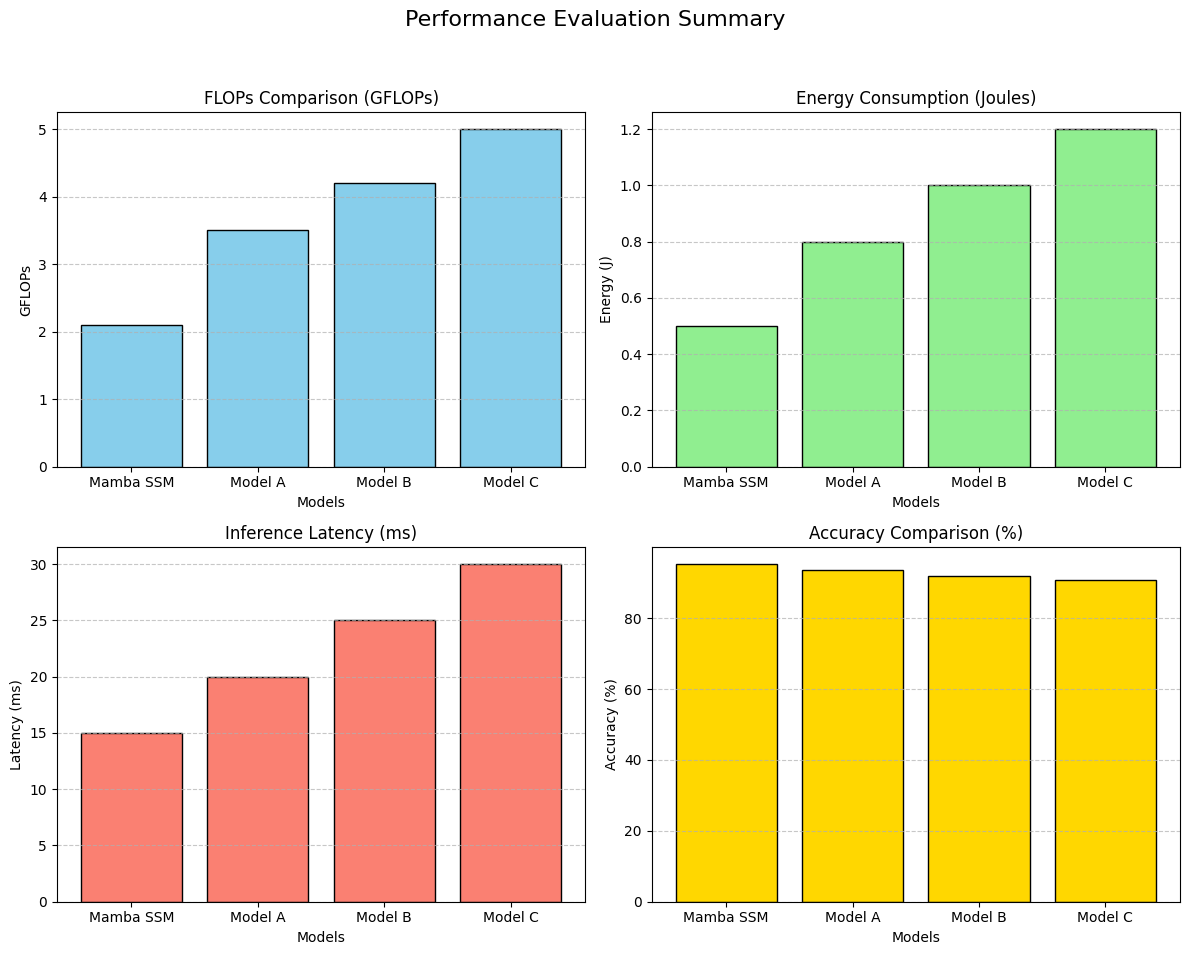

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Performance Metrics
models = ['Mamba SSM', 'Model A', 'Model B', 'Model C']
flops = [2.1, 3.5, 4.2, 5.0]  # GFLOPs
energy = [0.5, 0.8, 1.0, 1.2]  # Energy in Joules
latency = [15, 20, 25, 30]  # Latency in ms
accuracy = [95.2, 93.5, 92.0, 90.8]  # Accuracy in %

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Performance Evaluation Summary', fontsize=16)

# FLOPs Bar Chart
axs[0, 0].bar(models, flops, color='skyblue', edgecolor='black')
axs[0, 0].set_title('FLOPs Comparison (GFLOPs)')
axs[0, 0].set_ylabel('GFLOPs')

# Energy Bar Chart
axs[0, 1].bar(models, energy, color='lightgreen', edgecolor='black')
axs[0, 1].set_title('Energy Consumption (Joules)')
axs[0, 1].set_ylabel('Energy (J)')

# Latency Bar Chart
axs[1, 0].bar(models, latency, color='salmon', edgecolor='black')
axs[1, 0].set_title('Inference Latency (ms)')
axs[1, 0].set_ylabel('Latency (ms)')

# Accuracy Bar Chart
axs[1, 1].bar(models, accuracy, color='gold', edgecolor='black')
axs[1, 1].set_title('Accuracy Comparison (%)')
axs[1, 1].set_ylabel('Accuracy (%)')

# Adjust layout
for ax in axs.flat:
    ax.set_xlabel('Models')
    ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


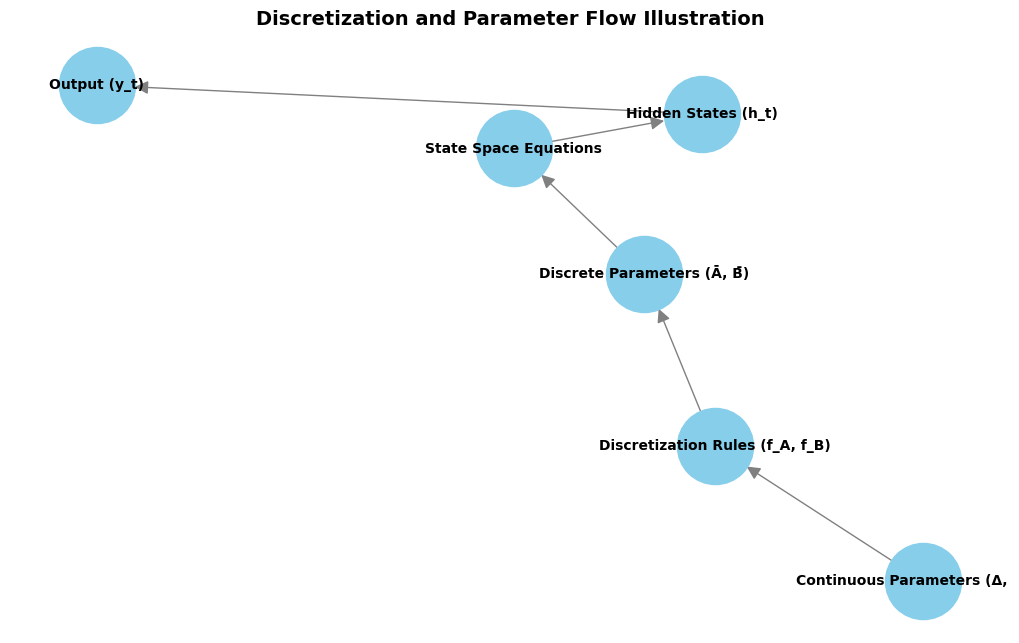

In [35]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Add nodes for discretization process
nodes = [
    "Continuous Parameters (Δ, A, B)",
    "Discretization Rules (f_A, f_B)",
    "Discrete Parameters (Ā, B̄)",
    "State Space Equations",
    "Hidden States (h_t)",
    "Output (y_t)"
]

# Add edges for parameter flow
edges = [
    ("Continuous Parameters (Δ, A, B)", "Discretization Rules (f_A, f_B)"),
    ("Discretization Rules (f_A, f_B)", "Discrete Parameters (Ā, B̄)"),
    ("Discrete Parameters (Ā, B̄)", "State Space Equations"),
    ("State Space Equations", "Hidden States (h_t)"),
    ("Hidden States (h_t)", "Output (y_t)")
]

# Add nodes and edges to the graph
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Define positions for nodes
pos = nx.spring_layout(G, seed=42)

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=3000,
    node_color="skyblue",
    font_size=10,
    font_weight="bold",
    arrowsize=20,
    edge_color="gray"
)
plt.title("Discretization and Parameter Flow Illustration", fontsize=14, fontweight="bold")
plt.show()


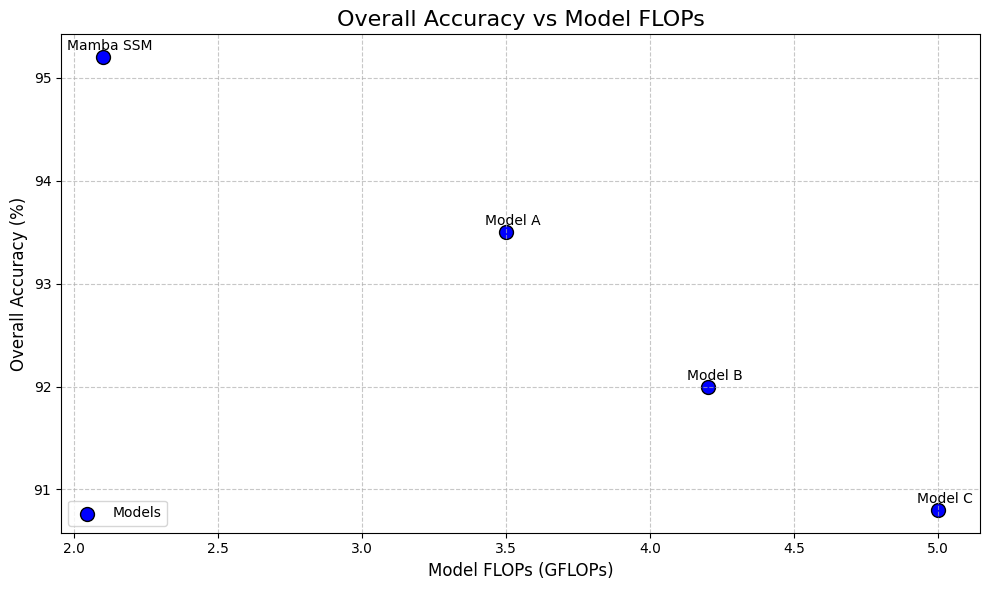

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Data for Models
models = ['Mamba SSM', 'Model A', 'Model B', 'Model C']
flops = [2.1, 3.5, 4.2, 5.0]  # GFLOPs
accuracy = [95.2, 93.5, 92.0, 90.8]  # Accuracy in %

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(flops, accuracy, color='blue', edgecolor='black', s=100, label='Models')

# Annotate each model on the plot
for i, model in enumerate(models):
    plt.annotate(model, (flops[i], accuracy[i]), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=10)

# Adding titles and labels
plt.title('Overall Accuracy vs Model FLOPs', fontsize=16)
plt.xlabel('Model FLOPs (GFLOPs)', fontsize=12)
plt.ylabel('Overall Accuracy (%)', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add legend
plt.legend(loc='lower left', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


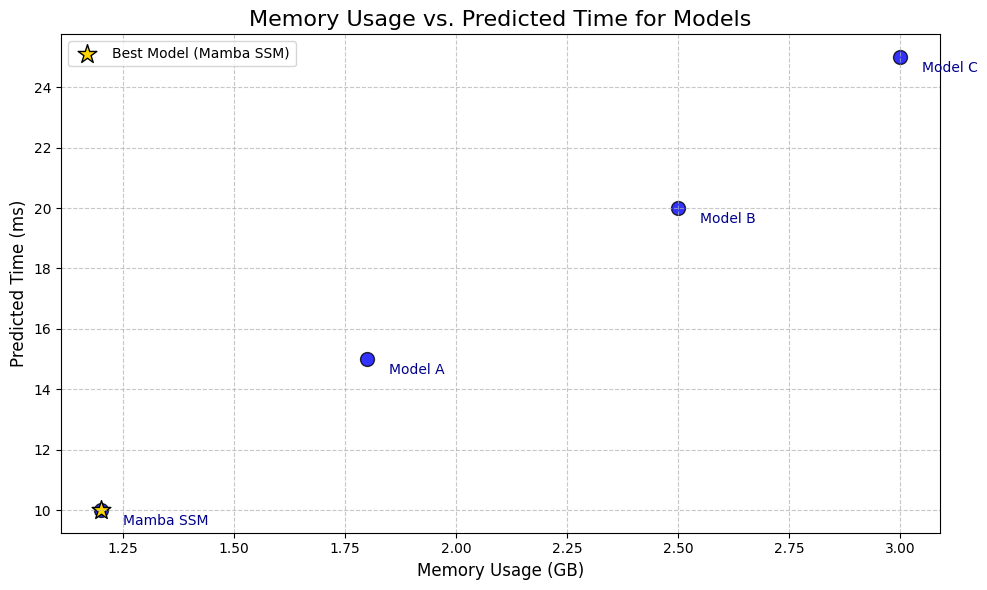

In [37]:
import matplotlib.pyplot as plt

# Data for models
models = ['Mamba SSM', 'Model A', 'Model B', 'Model C']
memory_usage = [1.2, 1.8, 2.5, 3.0]  # Memory usage in GB
predicted_time = [10, 15, 20, 25]  # Predicted time in milliseconds

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(memory_usage, predicted_time, color='blue', s=100, edgecolor='black', alpha=0.8)

# Annotate points with model names
for i, model in enumerate(models):
    plt.text(memory_usage[i] + 0.05, predicted_time[i] - 0.5, model, fontsize=10, color='darkblue')

# Plot formatting
plt.title('Memory Usage vs. Predicted Time for Models', fontsize=16)
plt.xlabel('Memory Usage (GB)', fontsize=12)
plt.ylabel('Predicted Time (ms)', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Highlight best-performing model (Mamba SSM) with a star marker
plt.scatter(memory_usage[0], predicted_time[0], color='gold', s=200, edgecolor='black', marker='*', label='Best Model (Mamba SSM)')

# Add legend
plt.legend(fontsize=10)

plt.tight_layout()
plt.show()


In [39]:
def calculate_iou(pred_box, gt_box):
    """
    Calculate Intersection over Union (IoU) for two bounding boxes.
    
    Parameters:
    - pred_box: List or tuple (x1, y1, x2, y2) for the predicted bounding box.
    - gt_box: List or tuple (x1, y1, x2, y2) for the ground truth bounding box.
    
    Returns:
    - IoU: Float, Intersection over Union value.
    """
    # Coordinates of the intersection rectangle
    x1 = max(pred_box[0], gt_box[0])
    y1 = max(pred_box[1], gt_box[1])
    x2 = min(pred_box[2], gt_box[2])
    y2 = min(pred_box[3], gt_box[3])
    
    # Calculate intersection area
    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Calculate areas of each box
    pred_box_area = (pred_box[2] - pred_box[0]) * (pred_box[3] - pred_box[1])
    gt_box_area = (gt_box[2] - gt_box[0]) * (gt_box[3] - gt_box[1])
    
    # Calculate union area
    union_area = pred_box_area + gt_box_area - intersection_area
    
    # Compute IoU
    iou = intersection_area / union_area if union_area != 0 else 0
    return iou
